# NLP - Project 1
## Rinehart Analysis
**Team**: *Jean Merlet, Konstantinos Georgiou, Matt Lane*

Check out the **[README](https://github.com/NLPaladins/rinehartAnalysis/blob/main/README.md)**


Or the current **[TODO](https://github.com/NLPaladins/rinehartAnalysis/blob/main/TODO.md)** list.

In [7]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

In [8]:
# Clone the repository if you're in Google Collab
def clone_project(is_collab: bool = False):
    print("Cloning Project..")
    !git clone https://github.com/NLPaladins/rinehartAnalysis.git
    print("Project cloned.")
       
print("Clone project?")
print("(If you do this you will ovewrite local changes on other files e.g. configs)")
print("Not needed if you're not on Google Collab")
btn = widgets.Button(description="Yes, clone")
btn.on_click(clone_project)
display(btn)

Clone project?
(If you do this you will ovewrite local changes on other files e.g. configs)
Not needed if you're not on Google Collab


Button(description='Yes, clone', style=ButtonStyle())

In [9]:
# Clone the repository if you're in Google Collab
def change_dir(is_collab: bool = False):
    try:
        print("Changing dir..")
        os.chdir('/content/rinehartAnalysis')
        print('done')
        print("Current dir:")
        print(os.getcwd())
        print("Dir Contents:")
        print(os.listdir())
    except Exception:
        print("Error: Project not cloned")
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(change_dir)
display(btn)

Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

### At any point, to save changes
click **File > Save a copy on Gihtub**

### Now go to files on the left, and open:
- rinehartAnalysis/confs/proj_1.yml

(Ctr+s) to save changes

## Load Libraries and setup

In [10]:
import traceback
import argparse
from importlib import reload as reload_lib
from pprint import pprint
import numpy as np

# Custom libs
from nlp_libs import Configuration, ColorizedLogger, ProcessedBook
# Import this way the libs you want to dynamically change and reload 
# import nlp_libs.books.processed_book as books_lib # Comment out until Class is finalized

### Libraries Overview
All the libraries are located under *"\<project root>/nlp_libs"*
- ***ProcessedBook***: Loc: **books/processed_book.py**, Desc: *Book Pre-processor*
- ***Configuration***: Loc: **configuration/configuration.py**, Desc: *Configuration Loader*
- ***ColorizedLogger***: Loc: **fancy_logger/colorized_logger.py**, Desc: *Logger with formatted text capabilities*

In [11]:
# The path of configuration and log save path
config_path = "confs/proj_1.yml"  # Open files > confs > proj_1.yml to edit temporalily. Commit to save permanently
# !cat "$config_path"
log_path = "logs/proj_1.log"  # Open files > logs > proj_1.log to debug logs of previous runs

In [12]:
# The logger
logger = ColorizedLogger(logger_name='Notebook', color='cyan')
ColorizedLogger.setup_logger(log_path=log_path, debug=False, clear_log=True)

2021-09-26 19:52:08 FancyLogger  INFO     Logger is set. Log file path: /Users/6j9/classes/ece_692/project1/rinehartAnalysis/logs/proj_1.log


In [89]:
# Load the configuration
conf = Configuration(config_src=config_path)
# Get the books dict
books = conf.get_config('data_loader')['config']['books']
pprint(books)  # Pretty print the books dict

2021-09-26 20:34:34 Config       INFO     Configuration file loaded successfully from path: /Users/6j9/classes/ece_692/project1/rinehartAnalysis/confs/proj_1.yml
2021-09-26 20:34:34 Config       INFO     Configuration Tag: proj1


{'K': {'crime_type': 'example',
       'detective': ['man1', 'man2'],
       'suspects': [{'Sidney Page': ['Sidney Page',
                                     'Miss Sidney',
                                     'Miss Page',
                                     'Sidney']},
                    {'Moyne': ['Moyne']},
                    {'Christine Lorenz': ['Christine Lorenz',
                                          'Christine',
                                          'Lorenz']},
                    {'Christine Howe': ['Christine Howe']},
                    {'Wilson Marriage': ['Wilson Marriage', 'Wilson']},
                    {'Carlotta Harrison': ['Carlotta Harrison',
                                           'Carlotta',
                                           'Miss Harrison',
                                           'Harrison']},
                    {'Tillie': ['Tillie']},
                    {'Palmer Howe': ['Palmer Howe', 'Palmer', 'Howe']},
                    {'Harriet 

## Exploration

In [14]:
import urllib.request
import re
from typing import *

In [78]:
class ProcessedBook:
    title: str
    url: str
    detectives: List[str]
    suspects: List[str]
    crime_type: str

    def __init__(self, title: str, metadata: Dict, make_lower: bool = True):
        """
        raw holds the books as a single string.
        clean holds the books as a list of lowercase lines starting
        from the first chapter and ending with the last sentence.
        """
        self.title = title
        self.url = metadata['url']
        self.detectives = metadata['detectives']
        self.suspects = metadata['suspects']
        self.crime_type = metadata['crime']
        self.raw = self.read_book_from_proj_gut(self.url)
        if make_lower:
            lines = self.raw.lower()
        else:
            lines = self.raw
        loins = re.sub(r'\r\n', r'\n',self.raw)
        loins = re.findall(r'.*\n', loins)
        self.lines = self.clean_lines(lines=lines)
        self.clean = self.get_clean_book(make_lower=make_lower)

    @staticmethod
    def read_book_from_proj_gut(book_url: str) -> str:
        req = urllib.request.Request(book_url)
        client = urllib.request.urlopen(req)
        page = client.read()
        return page.decode('utf-8')

    def get_clean_book(self, make_lower: bool = True) -> List[str]:
        if make_lower:
            lines = self.raw.lower()
        else:
            lines = self.raw
        lines = lines.replace('\r\n', '\n').split('\n')
        lines = self.clean_lines(lines)
        chapters = self.lines_to_chapters(lines)
        return chapters

    def clean_lines(self, lines: List[str]) -> List[str]:
        clean_lines = []
        start = False
        for line in lines:
            if re.match(r'^chapter i\.', line):
                clean_lines.append(line)
                start = True
                continue
            if not start:
                continue
            if re.match(r'^\*\*\* end of the project gutenberg ebook', line):
                break
            if self.pass_clean_filter(line):
                clean_lines.append(line)
        return clean_lines

    @staticmethod
    def lines_to_chapters(lines: List[str]) -> List[str]:
        chapters = []
        sentences = []
        current_sent = ''
        for i, line in enumerate(lines):
            # add chapter as 1st sentence
            if re.match(r'^chapter [ivxlcdm]+\.$', line):
                if sentences:
                    chapters.append(sentences)
                sentences = [line]
                add_chapter_title = True
                continue
            # add chapter title as 2nd sentence
            elif add_chapter_title:
                sentences.append(line)
                add_chapter_title = False
                continue
            sents = re.findall(r' *((?:mr\.|mrs.|[^\.\?!])*)(?<!mr)(?<!mrs)[\.\?!]', line)
            # if no sentence end is detected
            if not sents:
                if current_sent == '':
                    current_sent = line
                else:
                    current_sent += ' ' + line
            # if at least one sentence end is detected
            else:
                for group in sents:
                    if current_sent != '':
                        current_sent += ' ' + group
                        sentences.append(current_sent)
                    else:
                        sentences.append(group)
                    current_sent = ''
                # set the next sentence to its start if there is one
                sent_end = re.search(r'(?<!mr)(?<!mrs)[\.\?!] ((?:mr\.|mrs\.|[^\.\?!])*)$', line)
                if sent_end is not None:
                    current_sent = sent_end.groups()[0]
        return chapters

    @staticmethod
    def pass_clean_filter(line: str) -> bool:
        # removing the illustration lines and empty lines
        # can add other filters here as needed
        if line == '' or re.match(r'illustration:|\[illustration\]', line):
            return False
        else:
            return True

    @staticmethod
    def get_characters_per_chapter(chapter): 
        found_character_list = []
        search_string = re.compile(rf'[A-Z][a-z]+(?:\s|,|.|\.\s)[A-Z][a-z]+(?:\s[A-Z][a-z]+)?')
        #get characters per sentence in chapter
        for sentence in chapter:
            res = re.findall(search_string, sentence)
            found_character_list.append(res)

        unique_characters = list(np.concatenate(found_character_list))
        return found_character_list, unique_characters
      
        
    ##
    ## @Warning: Currently only works with all text as upper case.  
    ##
    def get_all_characters_per_novel(self):
        preceding_words_to_ditch = ['After', 'Although', 'And', 'As', 'At',
         'Before', 'Both', 'But', 'Did', 'For', 
         'Good', 'Had', 'Has', 'Home', 'If', 'Is',
         'Leaving', 'Like', 'No', 'Nice', 'Old', 'On', 'Or',
         'Poor', 'Send', 'So', 'That', 'Tell', 'The', 'Thank', 
         'To', 'Was', 'Whatever', 'When', 'Where', 'While', 
         'With','Your', 
          #Specific Places
         'African', 'Zion', 'New','Country', 'Greenwood', 'Western', 'American', 'Bar', 'Chestnut', 'Queen'
        ]
        
        book_by_chapter = self.lines_to_chapters(self.lines)
        
        totalUniqueList = []
        for chapter in book_by_chapter: 

            characterProgression, uniqueCharacters = get_characters_per_chapter(chapter)
            totalUniqueList = [*totalUniqueList, *uniqueCharacters]

        totalUnique = set(totalUniqueList)
        
        joined_preceding_words_to_lose = '|'.join(preceding_words_to_ditch)
        preceding_word_to_lose_regex = fr'^(?!{joined_preceding_words_to_lose}).*$'
        regex = re.compile(preceding_word_to_lose_regex)
        filtered_people = list(filter(regex.match, totalUnique))
        
        return filtered_people
    
    def get_total_sentences(self):
        return sum([len(chapter) - 2 for chapter in self.clean])

    def get_chapter(self, chapter: int) -> str:
        return self.clean[chapter - 1]

    def extract_character_names(self):
        lines_by_chapter = self.lines_to_chapters(self.lines)
        for chapter in lines_by_chapter: 
            print(chapter)    

# Analysis Functions

In [69]:
def get_earliest_chapter_sentence_from_name_lists(book, name_lists, n=0, first=True):
    '''
    Takes in a list of lists, where
    each list in this list of lists is a
    list of aliases for a single character.
    
    Returns a dictionary with character names
    as keys and a list with chapter number as
    the first element and sentence number as the
    second element.
    '''
    first_mentioned = {}
    for aliases in name_lists:
        alias_matcher = '|'.join(aliases)
        found_match = False
        for chapter_num, chapter in enumerate(book.clean):
            for sent_num, sentence in enumerate(chapter[2:]):
                match = re.search(alias_matcher, sentence)
                if match:
                    if not found_match:
                        first_mentioned[aliases[0]] = [chapter_num + 1, sent_num + 1, []]
                    found_match = True
                    if n > 0:
                        words = get_n_words(book, alias_matcher, chapter_num, sent_num, n)
                        first_mentioned[aliases[0]][-1].append(words)
                    if first:
                        break
            if first and found_match:
                break
    return first_mentioned

def get_n_words(book, alias_matcher, chapter_num, sent_num, n):
    sents = '. '.join(book.clean[chapter_num][sent_num + 1: sent_num + 4])
    words = re.search('((?:\S+ ){0,' + str(n) + '}\S?(?:' + alias_matcher + ')\S?(?: \S+){0,' + str(n) + '})', sents).group(0)
    return words

def get_co_occurence(book, name_lists, n_sents=2):
    assert len(name_lists) == 2
    mentions_a, mentions_b = {}, {}
    dets, perp = name_lists[0], name_lists[1]
    dets_matcher = '|'.join(dets)
    perp_matcher = '|'.join(perp)
    for chapter_num, chapter in enumerate(book.clean):
        mentions_a[chapter_num] = []
        mentions_b[chapter_num] = []
        for sent_num, sentence in enumerate(chapter[2:]):
            match_a = re.search(dets_matcher, sentence)
            match_b = re.search(perp_matcher, sentence)
            if match_a:
                mentions_a[chapter_num].append(sent_num)
            if match_b:
                mentions_b[chapter_num].append(sent_num)
    co_occurences = []
    for chapter_a, sent_nums_a in mentions_a.items():
        for chapter_b, sent_nums_b in mentions_b.items():
            if chapter_a == chapter_b:
                for sent_num_a in sent_nums_a:
                    for sent_num_b in sent_nums_b:
                        if sent_num_a > sent_num_b and sent_num_a - sent_num_b <= n_sents:
                            sents = book.clean[chapter_a][2:][sent_num_b:sent_num_a+1]
                            co_occurences.append([chapter_a, sent_num_b, sent_num_a, sents])
                        if sent_num_b > sent_num_a and sent_num_b - sent_num_a <= n_sents:
                            sents = book.clean[chapter_a][2:][sent_num_a:sent_num_b+1]
                            co_occurences.append([chapter_a, sent_num_a, sent_num_b, sents])
    return co_occurences

In [124]:
def get_analysis_formats(metadata):
    suspects, perp, dets, co_ocs, crime = [], [], [], [], []
    
    for aliases in metadata['suspects']:
        for _, values in aliases.items():
            suspects.append(values)
            
    for aliases in metadata['perpetrator']:
        for _, values in aliases.items():
            perp.append(values)
            co_ocs.append(values)
            
    for aliases in metadata['detectives']:
        for _, values in aliases.items():
            dets.append(values)
            co_ocs.append(values)
            
    dets = [[alias for alias in dets[0] if alias != 'detective']]
            
    return suspects, perp, dets, co_ocs, crime

# Plotting Functions

In [72]:
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import matplotlib.lines as mlines
import numpy

In [73]:
def create_locs_labels(book, suspects, perp, dets, co_ocs, crime):
    # divide the book into n chunks based on sentences
    total_sents = book.get_total_sentences()
    chapter_locs = []
    cum_sents = 0
    for chapter in book.clean:
        chapter_locs.append(cum_sents)
        cum_sents += len(chapter) - 2

    locs = []
    labels = []
    colors = []
    # other suspects
    for name, values in suspects.items():
        ch, sent_num, _ = values
        locs.append(chapter_locs[ch - 1] + sent_num)
        labels.append(name)
        colors.append('tab:blue')

    # perpetrator
    for name, values in perp.items():
        ch, sent_num, _ = values
        locs.append(chapter_locs[ch - 1] + sent_num)
        labels.append(name)
        colors.append('tab:red')

    # detective
    for name, values in dets.items():
        ch, sent_num, _ = values
        locs.append(chapter_locs[ch - 1] + sent_num)
        labels.append(name)
        colors.append('tab:green')

    # perp + det co-occurence
    for i, co_oc in enumerate(co_ocs):
        ch, sent_num, _, _ = co_oc
        locs.append(chapter_locs[ch - 1] + sent_num)
        labels.append(str(i + 1))
        colors.append('tab:orange')
    # crime occurence

    # add end of book
    locs.append(total_sents)
    labels.append('END')
    colors.append('tab:cyan')

    # sort
    idx = np.argsort(locs)
    locs = np.array(locs)[idx]
    labels = np.array(labels)[idx]
    colors = np.array(colors)[idx]

    return locs, labels, colors

In [74]:
def make_timeline(book, locs, labels, colors, num_x_labels=10, out_path=None):
    fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

    total_sents = book.get_total_sentences()
    x_ticks = np.arange(1, total_sents + 1, int(total_sents / num_x_labels))
    x_labels = [str(int((pct) * 100 / num_x_labels)) + '%' for pct in range(num_x_labels + 1)]
    ax.set_title('Timeline: The Circular Staircase', size=20)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, size=14)
    ax.get_yaxis().set_visible(False)

    # tiling the event heights with some nice levels
    levels = np.tile([-5, 5, -3, 3, -1, 1],
                     int(np.ceil(len(labels)/6)))[:len(labels)]

    # plot the event lines
    markerline, stemline, baseline = ax.stem(locs, levels,
                                             linefmt="C3-", basefmt="k-",
                                             use_line_collection=True)

    # make the marker circle look nicer
    plt.setp(markerline, mec="k", mfc="w", zorder=3)
    # shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(labels)))

    # annotate chapters
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for sent_num, lv, label, va in zip(locs, levels, labels, vert):
        ax.annotate(label, xy=(sent_num, lv), xytext=(6.5*len(label), np.sign(lv)*3),
                    textcoords="offset points", va=va, ha="right", size=12)

    # set colors
    colors = [plt_colors.to_rgba(color) for color in colors]
    stemline.set_colors(colors)

    # legend
    legend_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
    legend_names = ['other suspects', 'perpetrator', 'detective', 'co-occurences']
    proxies = [mlines.Line2D([], [], color=legend_colors[i], marker='_',
               markersize=15, label=legend_names[i]) for i in range(4)]
    fig.legend(handles=proxies, bbox_to_anchor=(1.0, 0.935), loc='upper left', fontsize=14)

    ax.margins(y=0.1)
    if out_path:
        plt.save(out_path, dpi=300)
    plt.show()

# Circular Staircase - Analysis

In [132]:
title, metadata = list(books.items())[0]
book = ProcessedBook(title=title, metadata=metadata)

In [133]:
suspects, perp, dets, co_ocs, crime = get_analysis_formats(metadata)

In [134]:
suspects = get_earliest_chapter_sentence_from_name_lists(book, suspects, 3, first=True)
perp = get_earliest_chapter_sentence_from_name_lists(book, perp, 3, first=True)
dets = get_earliest_chapter_sentence_from_name_lists(book, dets, 3, first=True)
co_ocs = get_co_occurence(book, dets_perp, n_sents=2)

In [135]:
crime = ''

# Circular Staircase - Plotting

In [136]:
locs, labels, colors = create_locs_labels(book, suspects, perp, dets, co_ocs, crime)

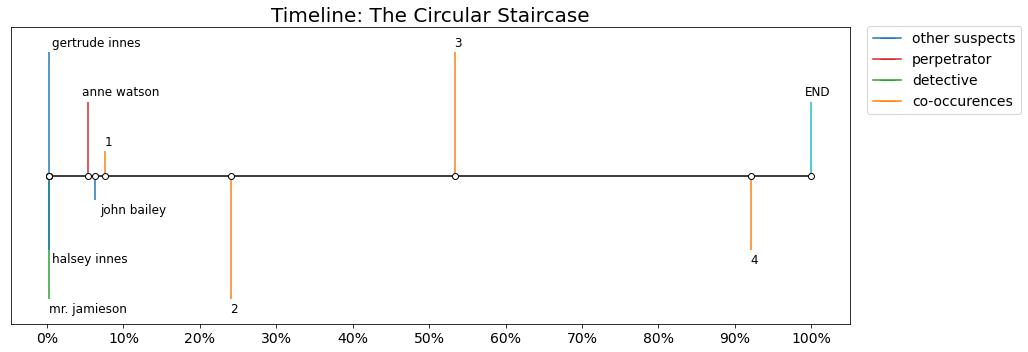

In [137]:
make_timeline(book, locs, labels, colors)

# The Man in the Lower Ten - Analysis

In [132]:
title, metadata = list(books.items())[1]
book = ProcessedBook(title=title, metadata=metadata)

In [133]:
suspects, perp, dets, co_ocs, crime = get_analysis_formats(metadata)

In [134]:
suspects = get_earliest_chapter_sentence_from_name_lists(book, suspects, 3, first=True)
perp = get_earliest_chapter_sentence_from_name_lists(book, perp, 3, first=True)
dets = get_earliest_chapter_sentence_from_name_lists(book, dets, 3, first=True)
co_ocs = get_co_occurence(book, dets_perp, n_sents=2)

In [135]:
crime = ''

# The Man in the Lower Ten - Plotting

In [136]:
locs, labels, colors = create_locs_labels(book, suspects, perp, dets, co_ocs, crime)

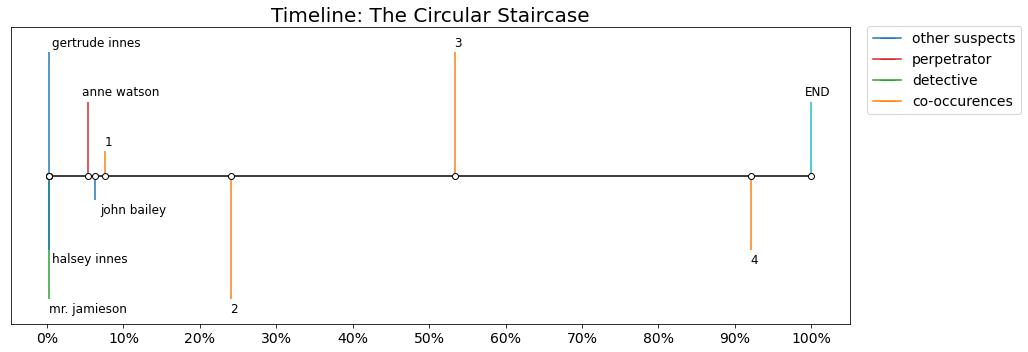

In [137]:
make_timeline(book, locs, labels, colors)

# The After House - Analysis

In [22]:
title, metadata = list(books.items())[2]
book = ProcessedBook(title=title, metadata=metadata) 

other_suspects = []

dets_perp = []

In [13]:
suspects = get_earliest_chapter_sentence_from_name_lists(book, other_suspects, 3, first=True)
suspects

{'gertrude innes': [1, 15, ['eleven then, and gertrude was seven. all']],
 'john bailey': [3, 48, ['let me present john bailey, only you must']],
 'halsey innes': [1, 15, ['his two children. halsey was eleven then,']]}

In [14]:
perp = get_earliest_chapter_sentence_from_name_lists(book, [dets_perp[1]], 3, first=True)
perp

{'anne watson': [2, 140, ['her name was anne watson, and i dined']]}

In [15]:
dets_list = [[alias for alias in dets_perp[0] if alias != 'detective']]
dets = get_earliest_chapter_sentence_from_name_lists(book, dets_list, 3, first=True)
dets

{'mr. jamieson': [1, 12, ['what i know. mr. jamieson, the detective, said']]}

In [16]:
co_ocs = get_co_occurence(book, dets_perp, n_sents=2)

# The After House - Plotting

In [22]:
title, metadata = list(books.items())[2]
book = ProcessedBook(title=title, metadata=metadata) 

other_suspects = []

dets_perp = []

# The Case of Jennifer Bryce - Analysis

In [22]:
title, metadata = list(books.items())[2]
book = ProcessedBook(title=title, metadata=metadata) 

other_suspects = []

dets_perp = []

In [13]:
suspects = get_earliest_chapter_sentence_from_name_lists(book, other_suspects, 3, first=True)
suspects

{'gertrude innes': [1, 15, ['eleven then, and gertrude was seven. all']],
 'john bailey': [3, 48, ['let me present john bailey, only you must']],
 'halsey innes': [1, 15, ['his two children. halsey was eleven then,']]}

In [14]:
perp = get_earliest_chapter_sentence_from_name_lists(book, [dets_perp[1]], 3, first=True)
perp

{'anne watson': [2, 140, ['her name was anne watson, and i dined']]}

In [15]:
dets_list = [[alias for alias in dets_perp[0] if alias != 'detective']]
dets = get_earliest_chapter_sentence_from_name_lists(book, dets_list, 3, first=True)
dets

{'mr. jamieson': [1, 12, ['what i know. mr. jamieson, the detective, said']]}

In [16]:
co_ocs = get_co_occurence(book, dets_perp, n_sents=2)

# The Case of Jennifer Bryce - Plotting

# K - Analysis

In [12]:
# Load Circlular Staircase example
title, metadata = list(books.items())[0]
book = ProcessedBook(title=title, metadata=metadata) 

other_suspects = [['gertrude innes', 'miss gertrude innes', 'miss gertrude', 'gertrude', 'miss innes', 'mis’ innes'],
                  ['john bailey', 'jack bailey', 'mr. bailey', 'bailey', 'alex', 'alexander graham'],
                  ['halsey innes', 'mr. halsey', 'halsey', 'mr. innes']]

dets_perp = [['mr. jamieson', 'mr. winters', 'detective', 'jamieson', 'winters'],
             ['anne watson', 'mrs. watson', 'mis’ watson']]

In [13]:
suspects = get_earliest_chapter_sentence_from_name_lists(book, other_suspects, 3, first=True)
suspects

{'gertrude innes': [1, 15, ['eleven then, and gertrude was seven. all']],
 'john bailey': [3, 48, ['let me present john bailey, only you must']],
 'halsey innes': [1, 15, ['his two children. halsey was eleven then,']]}

In [14]:
perp = get_earliest_chapter_sentence_from_name_lists(book, [dets_perp[1]], 3, first=True)
perp

{'anne watson': [2, 140, ['her name was anne watson, and i dined']]}

In [15]:
dets_list = [[alias for alias in dets_perp[0] if alias != 'detective']]
dets = get_earliest_chapter_sentence_from_name_lists(book, dets_list, 3, first=True)
dets

{'mr. jamieson': [1, 12, ['what i know. mr. jamieson, the detective, said']]}

In [16]:
co_ocs = get_co_occurence(book, dets_perp, n_sents=2)

# K - Plotting